# Задание 2.0

## Подключаем нужные библиотеки

In [151]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC

import optuna
from optuna.visualization import plot_optimization_history

## Загружаем Dataset из первого задания

In [3]:
df = pd.read_csv("d:/loan_train.csv")
df = df.dropna()
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,Male,No,0,Graduate,No,584900,0.0,15000000,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,458300,150800.0,12800000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,300000,0.0,6600000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,258300,235800.0,12000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,600000,0.0,14100000,360.0,1.0,Urban,Y


Заменяем объекты на цифровые значения с помощью LabelEncoding

In [70]:
le = LabelEncoder()
df_encode= df.copy()
for i, f in enumerate(df.select_dtypes(include="object")):
    le.fit(df_encode[f])  
    df_encode[f] = le.fit_transform(df_encode[f])
df_encode.head()

,Gender,Married,Dependents,Education,Self_Employed,Applicant_Income,Coapplicant_Income,Loan_Amount,Term,Credit_History,Area,Status
0,1,0,0,0,0,584900,0.0,15000000,360.0,1.0,2,1
1,1,1,1,0,0,458300,150800.0,12800000,360.0,1.0,0,0
2,1,1,0,0,1,300000,0.0,6600000,360.0,1.0,2,1
3,1,1,0,1,0,258300,235800.0,12000000,360.0,1.0,2,1
4,1,0,0,0,0,600000,0.0,14100000,360.0,1.0,2,1


In [71]:
X, y = df_encode.drop(columns='Status'), df_encode["Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)

## Задание 2.1. Построить более сложную модель с подбором гиперпараметров – 10б

В рамках данной точки необходимо использовать более сложную модель для решения задачи,  оптимизировать гиперпараметры и оценить ее качество.

Критерии оценки:

- Выбрана более сложная ML-модель - 1б.

- Произведен подбор гиперпараметров с использованием кросс-валидации - 4б.

- Выбранная модель обучена с лучшими подобранными значениями гиперпараметров - 4б.

- Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики - 1б.

Рассмотрим Logistic Regression, KNeighborsClassifier, RandomForestClassifier и SVC

## Logistic Regression

In [129]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_sc = clf.predict(X_test)
print(classification_report(y_test, y_pred_sc))

              precision    recall  f1-score   support

           0       0.92      0.29      0.44        38
           1       0.76      0.99      0.86        87

    accuracy                           0.78       125
   macro avg       0.84      0.64      0.65       125
weighted avg       0.81      0.78      0.73       125



In [120]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression())
    ]
)


parameters = {
    'scaler__with_mean': [True, False],
    'clf__C': np.linspace(0.01, 1, 10),
    'clf__penalty': ['l2', 'none'],
    'clf__random_state': [2023],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=10,
)

In [122]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=5,
             param_grid={'clf__C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'clf__penalty': ['l2', 'none'],
                         'clf__random_state': [2023],
                         'scaler__with_mean': [True, False]},
             verbose=10)

In [132]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))

knc__leaf_size: 1
knc__n_neighbors: 9
knc__weights: uniform
scaler__with_mean: True
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.79      0.29      0.42        38
           1       0.76      0.97      0.85        87

    accuracy                           0.76       125
   macro avg       0.77      0.63      0.64       125
weighted avg       0.77      0.76      0.72       125



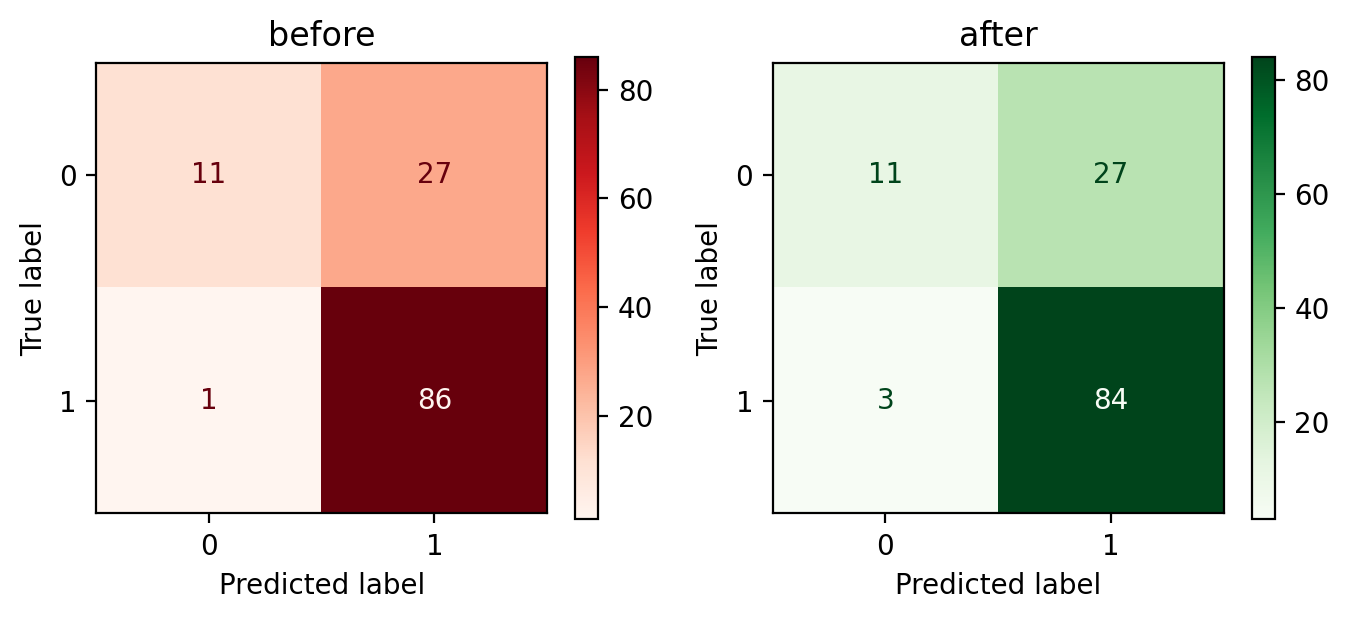

In [130]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_sc)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])


## KNeighborsClassifier

In [133]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.21      0.24        38
           1       0.68      0.75      0.71        87

    accuracy                           0.58       125
   macro avg       0.48      0.48      0.47       125
weighted avg       0.56      0.58      0.57       125



In [134]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('knc', KNeighborsClassifier())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    'knc__weights': ['uniform', 'distance'],
    'knc__leaf_size': np.arange(1,100,1),
    'knc__n_neighbors': np.arange(1,10,1),
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [136]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3564 candidates, totalling 17820 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knc', KNeighborsClassifier())]),
             n_jobs=5,
             param_grid={'knc__leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'knc__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'knc__weights': ['uniform', 'distance'],
                         'scaler__with_mean': [True, False]},
             verbose=10)

In [137]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")


y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))

knc__leaf_size: 1
knc__n_neighbors: 9
knc__weights: uniform
scaler__with_mean: True
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.79      0.29      0.42        38
           1       0.76      0.97      0.85        87

    accuracy                           0.76       125
   macro avg       0.77      0.63      0.64       125
weighted avg       0.77      0.76      0.72       125



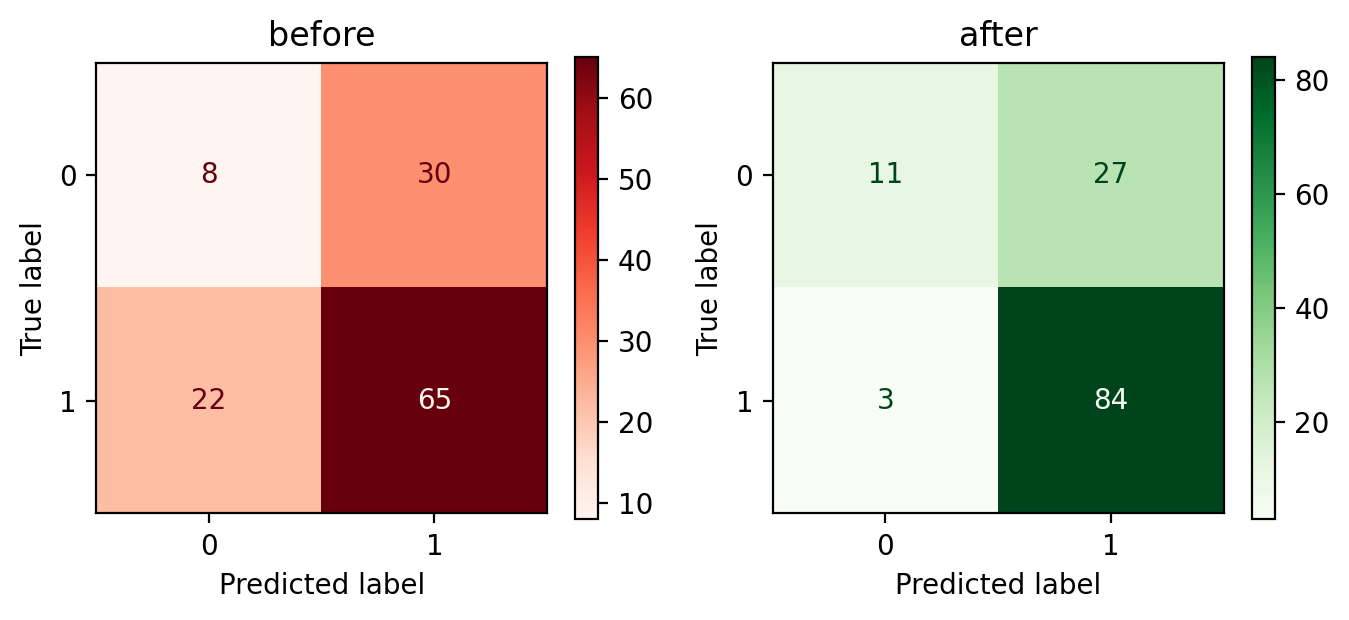

In [138]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## RandomForestClassifier

In [139]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred= rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.34      0.46        38
           1       0.76      0.93      0.84        87

    accuracy                           0.75       125
   macro avg       0.72      0.64      0.65       125
weighted avg       0.74      0.75      0.72       125



In [170]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('rfc', RandomForestClassifier())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    # 'rfc__n_estimators': np.arange(50,150,5),
    'rfc__max_depth': np.arange(1,20,1),
    'rfc__criterion': ['gini', 'entropy', 'log_loss'],
    'rfc__class_weight': ['balanced', 'balanced_subsample', None]
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [171]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'rfc__class_weight': ['balanced', 'balanced_subsample',
                                               None],
                         'rfc__criterion': ['gini', 'entropy', 'log_loss'],
                         'rfc__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'scaler__with_mean': [True, False]},
             verbose=1)

In [172]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))

rfc__class_weight: balanced_subsample
rfc__criterion: log_loss
rfc__max_depth: 17
scaler__with_mean: False
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.67      0.32      0.43        38
           1       0.76      0.93      0.84        87

    accuracy                           0.74       125
   macro avg       0.71      0.62      0.63       125
weighted avg       0.73      0.74      0.71       125



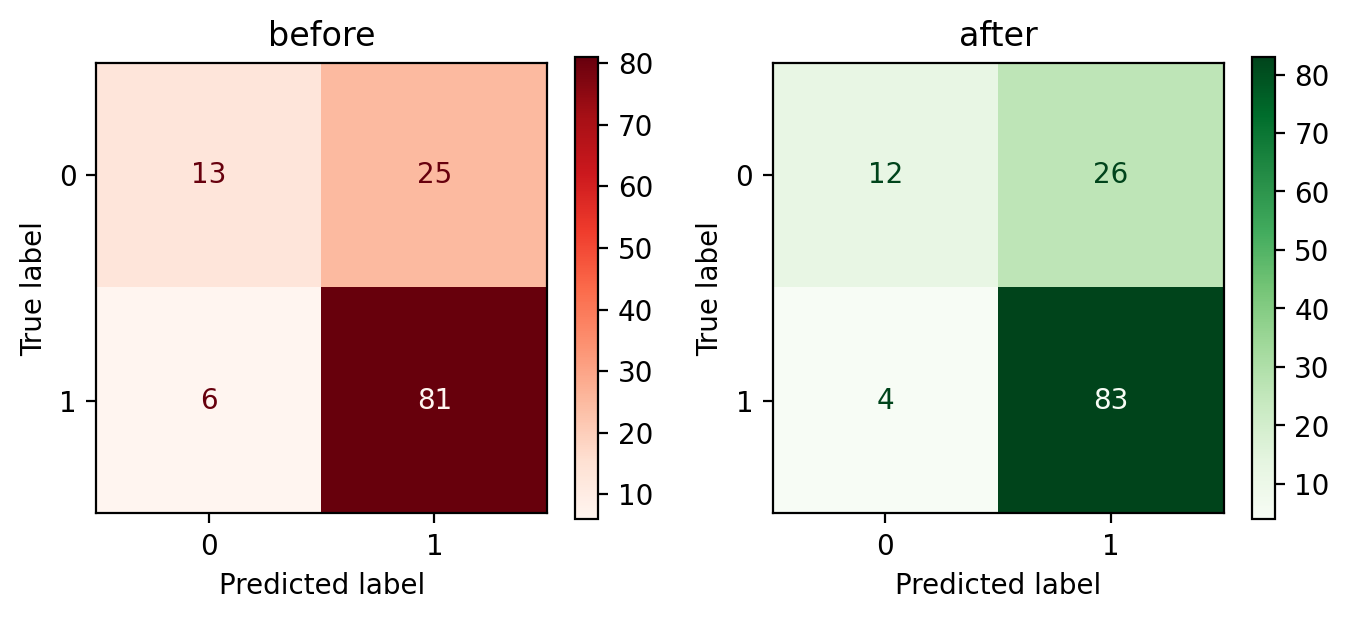

In [144]:
fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## SVC 

In [147]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.70      1.00      0.82        87

    accuracy                           0.70       125
   macro avg       0.35      0.50      0.41       125
weighted avg       0.48      0.70      0.57       125



In [156]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('svc', SVC())
    ]
)

parameters = {
    'scaler__with_mean': [True, False],
    'svc__C': 10**np.linspace(-10, 10, 21),
}


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    n_jobs=5,
    verbose=1,
)

In [157]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=5,
             param_grid={'scaler__with_mean': [True, False],
                         'svc__C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])},
             verbose=1)

In [161]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

y_pred_optimized = grid_search.best_estimator_.predict(X_test)
print('--------------------------------------------------------\n')
print('Classification report\n', classification_report(y_test, y_pred_optimized))

scaler__with_mean: True
svc__C: 1.0
--------------------------------------------------------

Classification report
               precision    recall  f1-score   support

           0       0.92      0.29      0.44        38
           1       0.76      0.99      0.86        87

    accuracy                           0.78       125
   macro avg       0.84      0.64      0.65       125
weighted avg       0.81      0.78      0.73       125



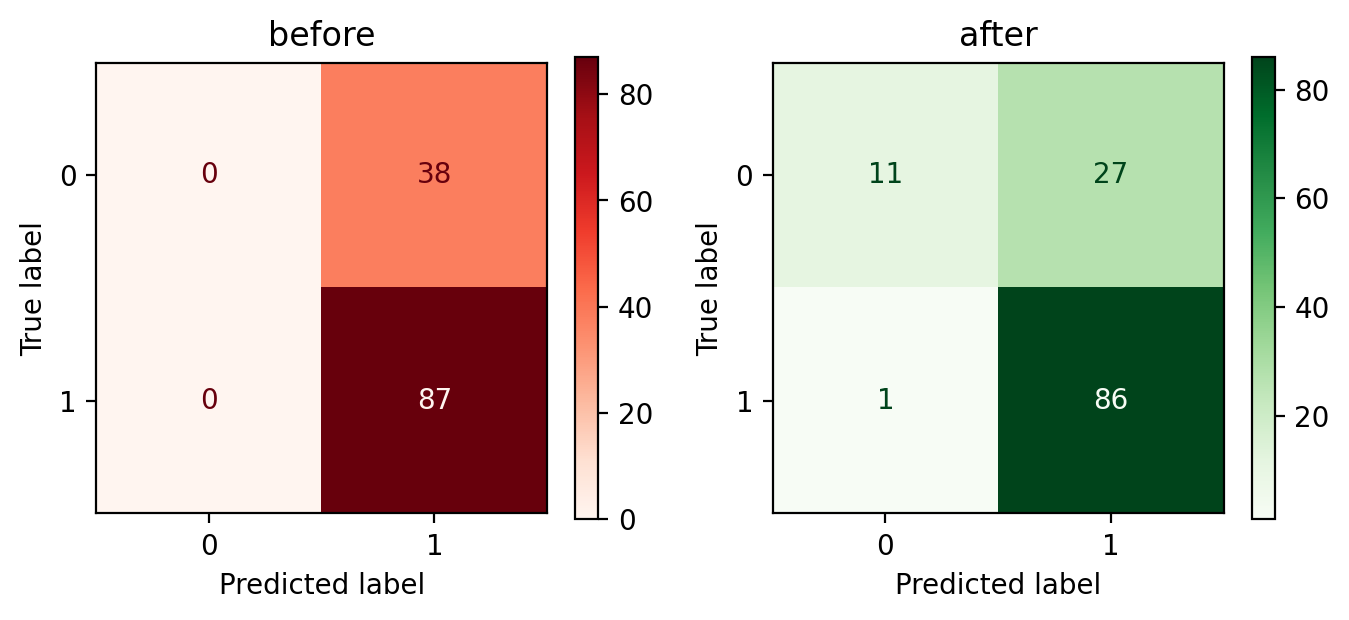

In [162]:

fig, axes = plt.subplots(ncols=2, dpi=200, figsize=(8,3))
axes[0].set_title("before")
axes[1].set_title("after")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(cmap='Reds', ax=axes[0])
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred_optimized)).plot(cmap='Greens', ax=axes[1])

## Оптимизация гиперпараметров с помощью Optuna

In [181]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest", "KNeighborsClassifier"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")

    elif classifier_name == "RandomForest":
        n_estimators = trial.suggest_int('n_estimators', 1, 100)
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        class_weight =  trial.suggest_categorical('class_weight',['balanced', 'balanced_subsample', None])
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=n_estimators, criterion=criterion, class_weight=class_weight)
        
    else:
        leaf_size = trial.suggest_int('leaf_size', 1, 100)
        n_neighbors = trial.suggest_int("n_neighbors", 1, 10)
        classifier_obj = KNeighborsClassifier(leaf_size=leaf_size, n_neighbors=n_neighbors)

    score = cross_val_score(classifier_obj, X_train,y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [182]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

[I 2024-03-01 16:03:31,216] A new study created in memory with name: no-name-8e08a4d1-5d83-4779-a259-534b8151c211
[I 2024-03-01 16:03:31,357] Trial 0 finished with value: 0.802258064516129 and parameters: {'classifier': 'RandomForest', 'n_estimators': 91, 'criterion': 'log_loss', 'class_weight': None, 'rf_max_depth': 12}. Best is trial 0 with value: 0.802258064516129.
[I 2024-03-01 16:03:31,416] Trial 1 finished with value: 0.7942150537634408 and parameters: {'classifier': 'RandomForest', 'n_estimators': 26, 'criterion': 'log_loss', 'class_weight': 'balanced_subsample', 'rf_max_depth': 4}. Best is trial 0 with value: 0.802258064516129.
[I 2024-03-01 16:03:31,442] Trial 2 finished with value: 0.7031397849462365 and parameters: {'classifier': 'RandomForest', 'n_estimators': 2, 'criterion': 'entropy', 'class_weight': 'balanced', 'rf_max_depth': 5}. Best is trial 0 with value: 0.802258064516129.
[I 2024-03-01 16:03:31,582] Trial 3 finished with value: 0.7941720430107527 and parameters: {'c

In [183]:
plot_optimization_history(study)

In [184]:
best_params = study.best_params
print(best_params) 

{'classifier': 'RandomForest', 'n_estimators': 92, 'criterion': 'log_loss', 'class_weight': None, 'rf_max_depth': 8}


In [185]:
rfc = RandomForestClassifier(best_params)
rfc.fit(X_train,y_train)
y_pred= rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.39      0.47        38
           1       0.77      0.87      0.82        87

    accuracy                           0.73       125
   macro avg       0.67      0.63      0.64       125
weighted avg       0.71      0.73      0.71       125



In [186]:
best_params.

KeyError: 1